<a href="https://colab.research.google.com/github/Rodz30/Complete-Python-3-Bootcamp/blob/master/LSTM1month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 672
lag_exp=24

In [0]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [0]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [0]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [0]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [0]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [0]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [26]:
import pandas as pd
series = pd.read_excel('/content/drive/My Drive/AL_WIND_07_12 (2).xlsx',index_col="DateTime")
series.head()

,Air temperature,Pressure,Wind speed,Wind direction,Power generated by system
DateTime,,,,,
2007-01-01 00:00:00,10.926,0.979103,9.014,229,33688.1
2007-01-01 01:00:00,9.919,0.979566,9.428,232,37261.9
2007-01-01 02:00:00,8.567,0.979937,8.700,236,30502.9
2007-01-01 03:00:00,7.877,0.980053,8.481,247,28419.2
2007-01-01 04:00:00,7.259,0.979867,8.383,256,27370.3


In [27]:
'''Drop all the features as we will not be having any in production'''
del series['Air temperature']
del series['Pressure']
del series['Wind direction']
del series['Power generated by system']
series.head()

,Wind speed
DateTime,
2007-01-01 00:00:00,9.014
2007-01-01 01:00:00,9.428
2007-01-01 02:00:00,8.700
2007-01-01 03:00:00,8.481
2007-01-01 04:00:00,8.383


In [28]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,Wind speed
DateTime,
2012-12-31 09:00:00,5.351
2012-12-31 10:00:00,5.375
2012-12-31 11:00:00,5.498
2012-12-31 12:00:00,4.973
2012-12-31 13:00:00,4.072


In [0]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [0]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [31]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
print(len(train))
print(len(test))


51877
672


In [0]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [33]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
51877/51877 [==============================] - 68s 1ms/step - loss: 0.0103
Epoch 1/1
51877/51877 [==============================] - 68s 1ms/step - loss: 0.0100
Epoch 1/1
51877/51877 [==============================] - 68s 1ms/step - loss: 0.0098
Epoch 1/1
51877/51877 [==============================] - 68s 1ms/step - loss: 0.0097
Epoch 1/1
51877/51877 [==============================] - 67s 1ms/step - loss: 0.0096
Epoch 1/1
51877/51877 [==============================] - 68s 1ms/step - loss: 0.0096
Epoch 1/1
51877/51877 [==============================] - 67s 1ms/step - loss: 0.0095


In [42]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=8.613844, Expected=8.346000
Hour=2, Predicted=7.551280, Expected=5.539000
Hour=3, Predicted=4.619949, Expected=4.623000
Hour=4, Predicted=4.095154, Expected=4.982000
Hour=5, Predicted=5.060335, Expected=6.133000
Hour=6, Predicted=6.341595, Expected=6.716000
Hour=7, Predicted=6.966971, Expected=6.015000
Hour=8, Predicted=6.250718, Expected=6.645000
Hour=9, Predicted=6.945242, Expected=7.758000
Hour=10, Predicted=8.264149, Expected=8.926000
Hour=11, Predicted=9.535368, Expected=8.587000
Hour=12, Predicted=9.308004, Expected=7.976000
Hour=13, Predicted=8.810229, Expected=7.486000
Hour=14, Predicted=8.248184, Expected=7.116000
Hour=15, Predicted=7.644317, Expected=6.595000
Hour=16, Predicted=6.907385, Expected=5.671000
Hour=17, Predicted=5.852546, Expected=5.614000
Hour=18, Predicted=5.601145, Expected=4.916000
Hour=19, Predicted=4.796669, Expected=4.532000
Hour=20, Predicted=4.305335, Expected=4.588000
Hour=21, Predicted=4.247392, Expected=4.345000
Hour=22, Predicted=3.8

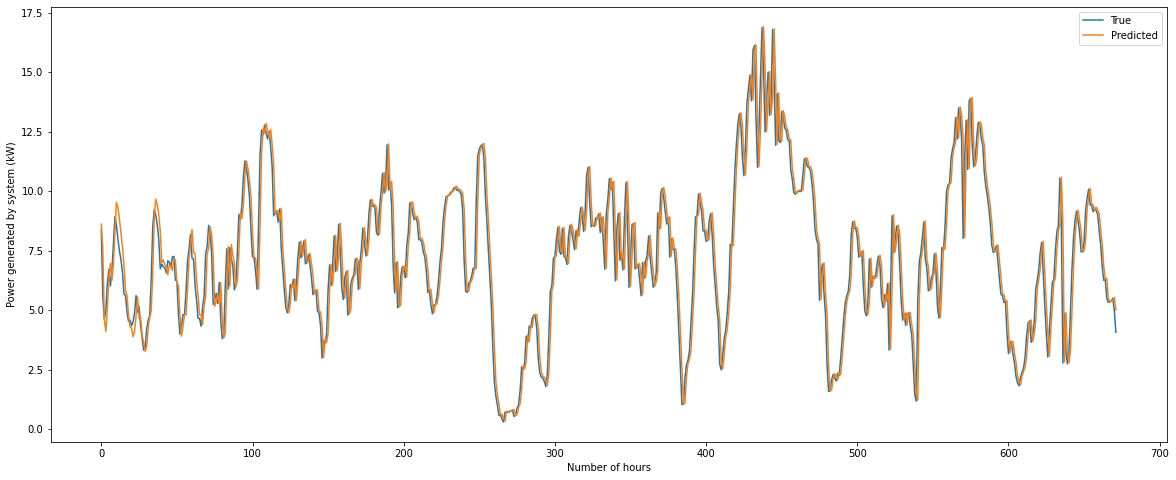

In [43]:
# line plot of observed vs predicted
pyplot.figure(figsize=(20,8))
pyplot.plot(expectations_plot, label="True")
pyplot.plot(predictions_plot, label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [44]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  12.858184329509644


In [45]:
from sklearn.metrics import explained_variance_score
print("expected variance score",explained_variance_score(expectations,predictions))


expected variance score 0.8837634024618046


In [46]:
from sklearn.metrics import max_error
print("max error:",max_error(expectations, predictions))

max error: 5.694701372399927


In [47]:
from sklearn.metrics import mean_absolute_error
print("mean absolute error:",mean_absolute_error(expectations, predictions))

mean absolute error: 0.7656459117007797


In [48]:
from sklearn.metrics import mean_squared_error
print("mean squared error:",mean_squared_error(expectations, predictions))

mean squared error: 1.0575548983690102


In [49]:
 from sklearn.metrics import mean_squared_error
 print("root mean squared error:",mean_squared_error(expectations, predictions, squared=False))


root mean squared error: 1.028374882214171


In [50]:
from sklearn.metrics import mean_squared_log_error
print("mean squared log error:",mean_squared_log_error(predictions, expectations))

mean squared log error: 0.020544670715669462


In [51]:
from sklearn.metrics import median_absolute_error
print("median absolute error:",median_absolute_error(expectations, predictions))

median absolute error: 0.5895436119139204


In [52]:
from sklearn.metrics import r2_score
print("r2 score:",r2_score(expectations, predictions))
print("r2 score variance weighted:",r2_score(expectations,predictions,multioutput='variance_weighted'))

r2 score: 0.8835362649113624
r2 score variance weighted: 0.8835362649113623


In [53]:
from sklearn.metrics import mean_poisson_deviance
print("mean poisson deviance:",mean_poisson_deviance(expectations,predictions))

mean poisson deviance: 0.16193254939333232


In [54]:
from sklearn.metrics import mean_gamma_deviance
print("mean gamma deviance:",mean_gamma_deviance(expectations, predictions))

mean gamma deviance: 0.0355701682001094
